In [8]:
from bs4 import BeautifulSoup as bs
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium import webdriver
import pandas as pd

In [9]:
def get_raw_data(url):
    driver = webdriver.Chrome()
    driver.get(url)
    WebDriverWait(driver, 5).until(EC.presence_of_element_located((By.ID, "live-table")))

    while True:
        # Find all current "Show more" links
        show_more_links = driver.find_elements(By.XPATH, "//span[contains(text(), 'Show more matches')]/parent::a")
        if not show_more_links:
            break  # No more links to click

        for link in show_more_links:
            try:
                # Scroll to the link to ensure it's visible
                driver.execute_script("arguments[0].scrollIntoView();", link)
                link.click()
                # Wait for the link to become stale (content expanded)
                WebDriverWait(driver, 5).until(EC.staleness_of(link))
            except Exception:
                pass  # Ignore if already expanded or error

    soup = bs(driver.page_source, 'html.parser')
    return soup

In [4]:
soup = get_raw_data('https://www.livesport.com/uk/football/england/premier-league-2023-2024/results/')

In [5]:
events = soup.find_all('div', class_='event__match event__match--withRowLink event__match--static event__match--twoLine')
last_event = soup.find_all('div', class_='event__match event__match--withRowLink event__match--static event__match--last event__match--twoLine')

In [6]:
events[-1].find('div', class_='event__time')

<div class="event__time">12.08. 12:30</div>

In [7]:
len(last_event)

44

* The match fixtures are structured in rounds, as if they were individual tables separating the first to the last event of each round
* You can use the events variable to get the regular events and the last_event to get the last event of each round respectively
* However, despite the data exploration, there seems to be a mismatch between the length of last event and number of rounds. Which is left to be solved
* Nonetheless, some progress was made.

# <h4>Fix the `last_event` length mismatch and craft a function to fully retrieve data</h4>

In [8]:
last_event[-1].find('div', class_='event__time')

<div class="event__time">11.08. 20:00</div>

In [9]:
ex = soup.find('div', class_='sportName soccer')

In [10]:
all_div = []
for div in ex.find_all('div', recursive=False):
    classes = div.get('class')
    if not 'event__match' in classes:
        continue 
    all_div.append(div)

In [11]:
classes

['event__match',
 'event__match--withRowLink',
 'event__match--static',
 'event__match--last',
 'event__match--twoLine']

In [12]:
all_div[-1].find('div', class_='wcl-participant_bctDY event__homeParticipant').text, all_div[-1].find('div', class_='wcl-participant_bctDY event__awayParticipant').text

('Burnley', 'Man City')

In [13]:
all_div[-1].find('div', class_='wcl-participant_bctDY event__homeParticipant').text

'Burnley'

In [14]:
dates = []
for match in all_div:
    dates.append(match.find('div', class_='event__time').text)

dates

['19.05. 16:00',
 '19.05. 16:00',
 '19.05. 16:00',
 '19.05. 16:00',
 '19.05. 16:00',
 '19.05. 16:00',
 '19.05. 16:00',
 '19.05. 16:00',
 '19.05. 16:00',
 '19.05. 16:00',
 '15.05. 20:00',
 '15.05. 19:45',
 '14.05. 20:00',
 '13.05. 20:00',
 '12.05. 16:30',
 '11.05. 17:30',
 '11.05. 15:00',
 '11.05. 15:00',
 '11.05. 15:00',
 '11.05. 15:00',
 '11.05. 15:00',
 '11.05. 15:00',
 '11.05. 12:30',
 '06.05. 20:00',
 '05.05. 16:30',
 '05.05. 14:00',
 '05.05. 14:00',
 '04.05. 17:30',
 '04.05. 15:00',
 '04.05. 15:00',
 '04.05. 15:00',
 '04.05. 12:30',
 '03.05. 20:00',
 '02.05. 19:30',
 '28.04. 16:30',
 '28.04. 14:00',
 '28.04. 14:00',
 '27.04. 20:00',
 '27.04. 17:30',
 '27.04. 15:00',
 '27.04. 15:00',
 '27.04. 15:00',
 '27.04. 15:00',
 '27.04. 12:30',
 '25.04. 20:00',
 '24.04. 20:00',
 '24.04. 20:00',
 '24.04. 20:00',
 '24.04. 19:45',
 '23.04. 20:00',
 '21.04. 16:30',
 '21.04. 15:00',
 '21.04. 15:00',
 '21.04. 13:30',
 '20.04. 19:30',
 '20.04. 15:00',
 '20.04. 15:00',
 '15.04. 20:00',
 '14.04. 16:30

In [ ]:
def get_matches():
    # soup = get_raw_data('https://www.livesport.com/uk/football/england/premier-league-2023-2024/results/')
    fixtures = soup.find('div', class_='sportName soccer')
    all_div = []
    for div in fixtures.find_all('div', recursive=False):
        classes = div.get('class')
        if not 'event__match' in classes:
            continue
        all_div.append(div)

    first_year = 2023
    second_year = 2024

    season = []
    dates = []
    for match in all_div:
        home_team = match.find('div', class_='wcl-participant_bctDY event__homeParticipant').text
        away_team = match.find('div', class_='wcl-participant_bctDY event__awayParticipant').text
        date_el = match.find('div', class_='event__time')
        date = date_el.get_text()
        home_score = match.find('span', class_='wcl-matchRowScore_fWR-Z wcl-isFinal_7U4ca event__score event__score--home').text
        away_score = match.find('span', class_='wcl-matchRowScore_fWR-Z wcl-isFinal_7U4ca event__score event__score--away').text

        
        day_month = date.split()[0].replace('.', '')
        time_part = date.split()[1]
        
        day = int(day_month[:2])
        month = int(day_month[2:])
        year = first_year if month >= 8 else second_year

        match_day = f"{year}-{month:02d}-{day:02d}"
            

        dates.append(date)
        season.append({
            'home_team': home_team,
            'away_team': away_team,
            'match_day': match_day,
            'time': time_part,
            'home_score': home_score,
            'away_score': away_score
        })

    return pd.DataFrame(season), dates

In [34]:
df, dates = get_matches()
# df.to_csv('epl_fixtures_2023_2024.csv', index=False)

In [35]:
df

,home_team,away_team,match_day,time,home_score,away_score
0,Arsenal,Everton,2024-05-19,16:00,2,1
1,Brentford,Newcastle,2024-05-19,16:00,2,4
2,Brighton,Man Utd,2024-05-19,16:00,0,2
3,Burnley,Nottm Forest,2024-05-19,16:00,1,2
4,Chelsea,Bournemouth,2024-05-19,16:00,2,1
...,...,...,...,...,...,...
375,Brighton,Luton,2023-08-12,15:00,4,1
376,Everton,Fulham,2023-08-12,15:00,0,1
377,Sheff Utd,Crystal Palace,2023-08-12,15:00,0,1
378,Arsenal,Nottm Forest,2023-08-12,12:30,2,1


* I was able to successfully extract the data, however there are some parts that still need attention
* The date column has no year associated

    ## <h4>Points to work on</h4>

* Add year and separate time from dates
* Refactor the function to iterate through all seasons
* Append all the data in one complete spreadsheet

In [31]:
first_year = 2023
second_year = 2024

match_day = []

for date in dates:
    day_month = date.split()[0].replace('.', '')
    time_part = date.split()[1]
    day = int(day_month[:2])
    month = int(day_month[2:])
    year = first_year if month >= 8 else second_year

    match_day.append(f"{year}-{month}-{day}")


In [3]:
def get_epl_fixtures(first_year, second_year):
    soup = get_raw_data(f'https://www.livesport.com/uk/football/england/premier-league-{first_year}-{second_year}/results/')
    fixtures = soup.find('div', class_='sportName soccer')
    all_div = []
    for div in fixtures.find_all('div', recursive=False):
        classes = div.get('class')
        if not 'event__match' in classes:
            continue
        all_div.append(div)

    season = []
    dates = []
    for match in all_div:
        home_team = match.find('div', class_='wcl-participant_bctDY event__homeParticipant').text
        away_team = match.find('div', class_='wcl-participant_bctDY event__awayParticipant').text
        date_el = match.find('div', class_='event__time')
        date = date_el.get_text()
        home_score = match.find('span', class_='wcl-matchRowScore_fWR-Z wcl-isFinal_7U4ca event__score event__score--home').text
        away_score = match.find('span', class_='wcl-matchRowScore_fWR-Z wcl-isFinal_7U4ca event__score event__score--away').text

        
        day_month = date.split()[0].replace('.', '')
        time_part = date.split()[1]
        
        day = int(day_month[:2])
        month = int(day_month[2:])
        year = first_year if month >= 8 else second_year

        match_day = f"{year}-{month:02d}-{day:02d}"
            
        season.append({
            'home_team': home_team,
            'away_team': away_team,
            'match_day': match_day,
            'time': time_part,
            'home_score': home_score,
            'away_score': away_score
        })

    return pd.DataFrame(season)

In [10]:
import time
initial_year = 2023
final_year = 1901

all_seasons = []
missing_seasons = []

while initial_year > final_year:
    try:
        time.sleep(3)  # Pause to avoid overwhelming the server
        df = get_epl_fixtures(initial_year, initial_year + 1)
        # Add a season column to identify which season each match belongs to
        df['season'] = f"{initial_year}-{initial_year + 1}"
        all_seasons.append(df)
        print(f"Completed season {initial_year}-{initial_year + 1}")
    except Exception as e:
        missing_seasons.append(f"{initial_year}-{initial_year + 1}")
        print(f"Error processing season {initial_year}-{initial_year + 1}: {e}")
    
    initial_year -= 1

# Concatenate all DataFrames into one
if all_seasons:
    complete_df = pd.concat(all_seasons, ignore_index=True)
    print(f"Total matches collected: {len(complete_df)}")
    
    # Save to CSV
    complete_df.to_csv('epl_all_seasons.csv', index=False)
    print("Data saved to epl_all_seasons.csv")

Completed season 2023-2024
Completed season 2022-2023
Completed season 2021-2022
Completed season 2020-2021


KeyboardInterrupt: 

* For simplicity sake, I am going to write a python script for scrapping the data

In [2]:
%%writefile get_fixtures.py

from bs4 import BeautifulSoup as bs
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium import webdriver
import pandas as pd

def get_raw_data(url):
    driver = webdriver.Chrome()
    driver.get(url)
    WebDriverWait(driver, 5).until(EC.presence_of_element_located((By.ID, "live-table")))

    while True:
        # Find all current "Show more" links
        show_more_links = driver.find_elements(By.XPATH, "//span[contains(text(), 'Show more matches')]/parent::a")
        if not show_more_links:
            break  # No more links to click

        for link in show_more_links:
            try:
                # Scroll to the link to ensure it's visible
                driver.execute_script("arguments[0].scrollIntoView();", link)
                link.click()
                # Wait for the link to become stale (content expanded)
                WebDriverWait(driver, 5).until(EC.staleness_of(link))
            except Exception:
                pass  # Ignore if already expanded or error

    soup = bs(driver.page_source, 'html.parser')
    driver.quit()
    return soup

def get_epl_fixtures(first_year, second_year):
    soup = get_raw_data(f'https://www.livesport.com/uk/football/england/premier-league-{first_year}-{second_year}/results/')
    fixtures = soup.find('div', class_='sportName soccer')
    all_div = []
    for div in fixtures.find_all('div', recursive=False):
        classes = div.get('class')
        if not 'event__match' in classes:
            continue
        all_div.append(div)

    season = []
    dates = []
    for match in all_div:
        home_team = match.find('div', class_='wcl-participant_bctDY event__homeParticipant').text
        away_team = match.find('div', class_='wcl-participant_bctDY event__awayParticipant').text
        date_el = match.find('div', class_='event__time')
        date = date_el.get_text()
        home_score = match.find('span', class_='wcl-matchRowScore_fWR-Z wcl-isFinal_7U4ca event__score event__score--home').text
        away_score = match.find('span', class_='wcl-matchRowScore_fWR-Z wcl-isFinal_7U4ca event__score event__score--away').text

        
        day_month = date.split()[0].replace('.', '')
        time_part = date.split()[1]
        
        day = int(day_month[:2])
        month = int(day_month[2:])
        year = first_year if month >= 8 else second_year

        match_day = f"{year}-{month:02d}-{day:02d}"
            
        season.append({
            'home_team': home_team,
            'away_team': away_team,
            'match_day': match_day,
            'time': time_part,
            'home_score': home_score,
            'away_score': away_score
        })

    return pd.DataFrame(season)

Overwriting get_fixtures.py


In [ ]:
import time
from get_fixtures import get_epl_fixtures
initial_year = 2023
final_year = 1901

all_seasons = []
missing_seasons = []

while initial_year > final_year:
    try:
        time.sleep(3)  # Pause to avoid overwhelming the server
        df = get_epl_fixtures(initial_year, initial_year + 1)
        # Add a season column to identify which season each match belongs to
        df['season'] = f"{initial_year}-{initial_year + 1}"
        all_seasons.append(df)
        print(f"Completed season {initial_year}-{initial_year + 1}")
    except Exception as e:
        missing_seasons.append(f"{initial_year}-{initial_year + 1}")
        print(f"Error processing season {initial_year}-{initial_year + 1}: {e}")
    
    initial_year -= 1


In [6]:
missing_seasons

['1945-1946',
 '1944-1945',
 '1943-1944',
 '1942-1943',
 '1941-1942',
 '1940-1941',
 '1939-1940',
 '1918-1919',
 '1917-1918',
 '1916-1917',
 '1915-1916']

In [ ]:
if all_seasons:
    complete_df = pd.concat(all_seasons, ignore_index=True)
    print(f"Total matches collected: {len(complete_df)}")
    
    # Save to CSV
    complete_df.to_csv('epl_all_seasons.csv', index=False)
    print("Data saved to epl_all_seasons.csv")

Total matches collected: 47328
Data saved to epl_all_seasons.csv


In [4]:
import pandas as pd

In [5]:
df = pd.read_csv('epl_all_seasons.csv')

In [5]:
df.dtypes

home_team     object
away_team     object
match_day     object
time          object
home_score     int64
away_score     int64
season        object
dtype: object

In [6]:
df['Winner'] = ''  # Initialize column first

for i, row in df.iterrows():
    if row['home_score'] > row['away_score']:
        df.loc[i, 'Winner'] = row['home_team']
    elif row['home_score'] < row['away_score']:
        df.loc[i, 'Winner'] = row['away_team']
    else:
        df.loc[i, 'Winner'] = 'Draw'

In [7]:
df

,home_team,away_team,match_day,time,home_score,away_score,season,Winner
0,Arsenal,Everton,2024-05-19,16:00,2,1,2023-2024,Arsenal
1,Brentford,Newcastle,2024-05-19,16:00,2,4,2023-2024,Newcastle
2,Brighton,Man Utd,2024-05-19,16:00,0,2,2023-2024,Man Utd
3,Burnley,Nottm Forest,2024-05-19,16:00,1,2,2023-2024,Nottm Forest
4,Chelsea,Bournemouth,2024-05-19,16:00,2,1,2023-2024,Chelsea
...,...,...,...,...,...,...,...,...
47323,Blackburn,Middlesbrough,1902-09-01,15:00,0,1,1902-1903,Middlesbrough
47324,Sheff Utd,Sheff Wed,1902-09-01,15:00,2,3,1902-1903,Sheff Wed
47325,Sunderland,Nottm Forest,1902-09-01,15:00,0,1,1902-1903,Nottm Forest
47326,West Brom,Everton,1902-09-01,15:00,2,1,1902-1903,West Brom


In [8]:
df.to_csv('epl_all_seasons.csv', index=False)

In [6]:
df['home_team'] = df['home_team'].str.replace('2', '', regex=False)
df['away_team'] = df['away_team'].str.replace('2', '', regex=False)

In [7]:
df['home_team'] = df['home_team'].str.replace('3', '', regex=False)
df['away_team'] = df['away_team'].str.replace('3', '', regex=False)

In [8]:
# Calculate home goals for each team
home_goals = df.groupby('home_team')['home_score'].sum()

# Calculate away goals for each team
away_goals = df.groupby('away_team')['away_score'].sum()

In [9]:
home_goals

home_team
Arsenal         4249
Aston Villa     3602
Barnsley          25
Birmingham      1766
Blackburn       2204
                ... 
West Brom       2462
West Ham        2291
Wigan            169
Wimbledon FC     394
Wolves          2203
Name: home_score, Length: 62, dtype: int64

In [10]:
total_goals = pd.concat([home_goals, away_goals], axis=1)
total_goals['total_goals'] = total_goals['home_score'] + total_goals['away_score']

In [11]:
total_goals

,home_score,away_score,total_goals
Arsenal,4249,2967,7216
Aston Villa,3602,2352,5954
Barnsley,25,12,37
Birmingham,1766,1147,2913
Blackburn,2204,1359,3563
...,...,...,...
West Brom,2462,1608,4070
West Ham,2291,1473,3764
Wigan,169,147,316
Wimbledon FC,394,308,702


In [12]:
total_goals = total_goals['total_goals'].sort_values(ascending=False)

In [13]:
total_goals

Arsenal          7216
Liverpool        6930
Man Utd          6735
Everton          6398
Man City         6025
                 ... 
Northampton        55
Swindon            47
Carlisle           43
Barnsley           37
Leyton Orient      37
Name: total_goals, Length: 62, dtype: int64

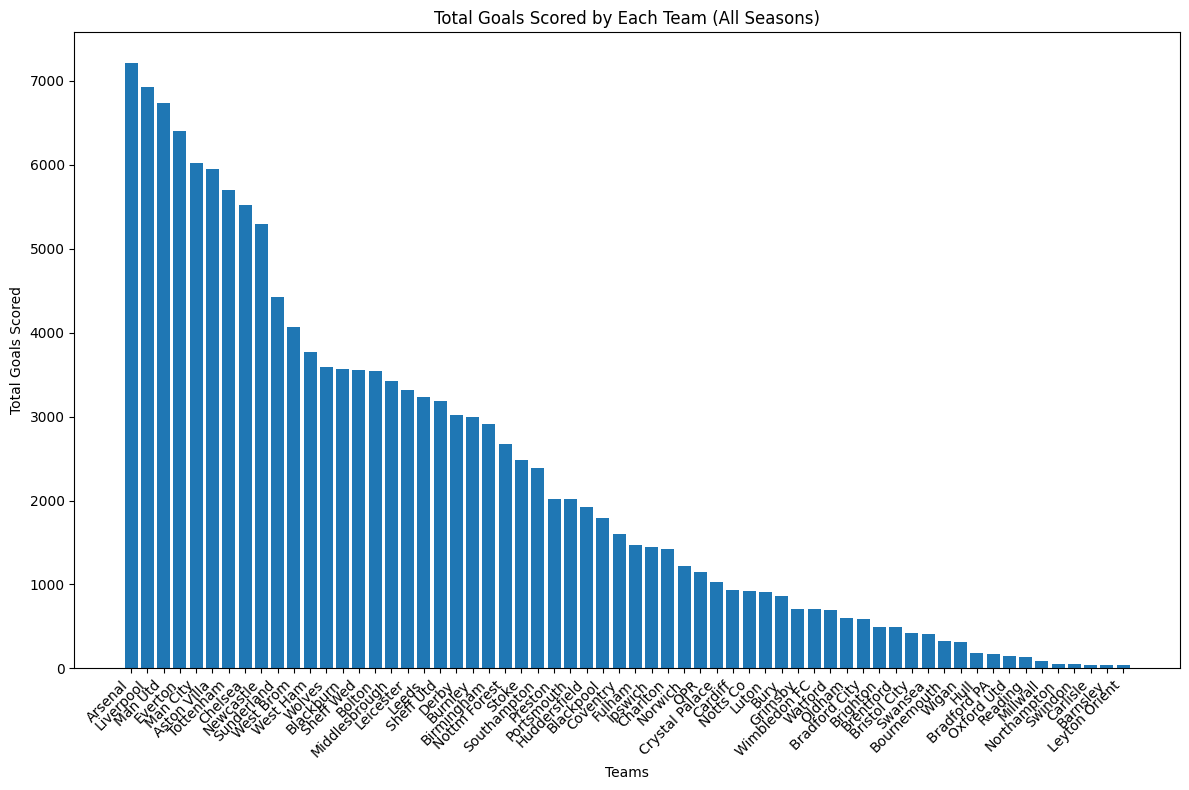

In [14]:
import matplotlib.pyplot as plt

# Create a bar plot
plt.figure(figsize=(12, 8))
plt.bar(range(len(total_goals)), total_goals.values)
plt.xlabel('Teams')
plt.ylabel('Total Goals Scored')
plt.title('Total Goals Scored by Each Team (All Seasons)')
plt.xticks(range(len(total_goals)), total_goals.index, rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [15]:
df

,home_team,away_team,match_day,time,home_score,away_score,season,Winner
0,Arsenal,Everton,2024-05-19,16:00,2,1,2023-2024,Arsenal
1,Brentford,Newcastle,2024-05-19,16:00,2,4,2023-2024,Newcastle
2,Brighton,Man Utd,2024-05-19,16:00,0,2,2023-2024,Man Utd
3,Burnley,Nottm Forest,2024-05-19,16:00,1,2,2023-2024,Nottm Forest
4,Chelsea,Bournemouth,2024-05-19,16:00,2,1,2023-2024,Chelsea
...,...,...,...,...,...,...,...,...
47323,Blackburn,Middlesbrough,1902-09-01,15:00,0,1,1902-1903,Middlesbrough
47324,Sheff Utd,Sheff Wed,1902-09-01,15:00,2,3,1902-1903,Sheff Wed
47325,Sunderland,Nottm Forest,1902-09-01,15:00,0,1,1902-1903,Nottm Forest
47326,West Brom,Everton,1902-09-01,15:00,2,1,1902-1903,West Brom


In [16]:
home_time = df.groupby('time')['home_score'].sum()
away_time = df.groupby('time')['away_score'].sum()

In [17]:
cons_time = pd.concat([home_time, away_time], axis=1)
cons_time['total_goals'] = cons_time['home_score'] + cons_time['away_score']

cons_time = cons_time['total_goals'].sort_values(ascending=False)

cons_time

time
15:00    92916
16:00    33682
20:00     2262
19:45     1446
17:30     1358
00:00      945
14:00      920
13:30      869
12:45      866
12:30      814
16:30      592
23:00      453
12:00      379
17:15      291
20:15      261
19:30      230
18:00      180
16:05      169
13:00      130
14:05      126
14:15      102
19:15       56
16:10       52
19:00       47
16:15       42
17:00       35
12:15       28
15:30       25
15:07       11
17:35        8
13:45        7
13:37        5
11:30        5
20:45        5
13:15        4
17:45        3
17:20        3
13:35        3
11:00        3
20:30        3
15:15        3
19:35        3
11:15        2
15:45        2
16:07        1
14:30        1
12:05        0
Name: total_goals, dtype: int64

TypeError: show() got an unexpected keyword argument 'grid'

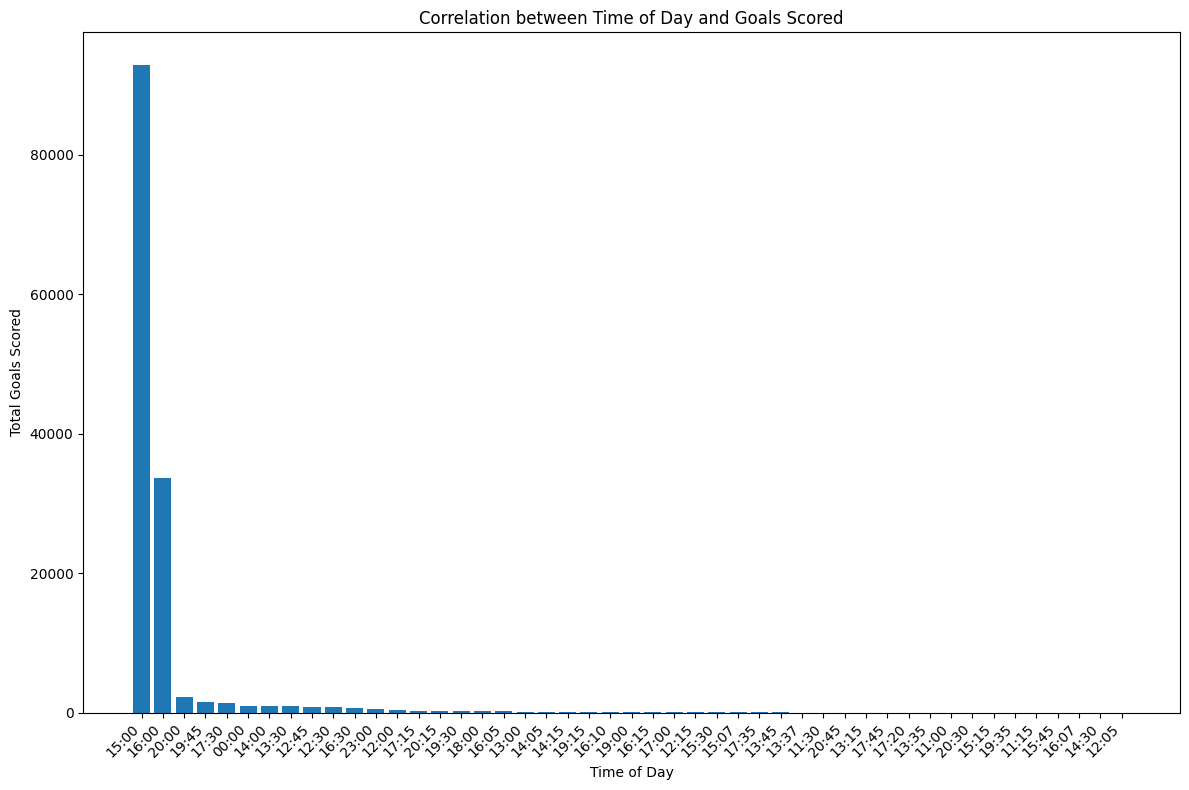

In [ ]:
plt.figure(figsize=(12, 8))
plt.bar(range(len(cons_time)), cons_time.values)
plt.xlabel('Time of Day')
plt.ylabel('Total Goals Scored')
plt.title('Correlation between Time of Day and Goals Scored')
plt.xticks(range(len(cons_time)), cons_time.index, rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [19]:
df

,home_team,away_team,match_day,time,home_score,away_score,season,Winner
0,Arsenal,Everton,2024-05-19,16:00,2,1,2023-2024,Arsenal
1,Brentford,Newcastle,2024-05-19,16:00,2,4,2023-2024,Newcastle
2,Brighton,Man Utd,2024-05-19,16:00,0,2,2023-2024,Man Utd
3,Burnley,Nottm Forest,2024-05-19,16:00,1,2,2023-2024,Nottm Forest
4,Chelsea,Bournemouth,2024-05-19,16:00,2,1,2023-2024,Chelsea
...,...,...,...,...,...,...,...,...
47323,Blackburn,Middlesbrough,1902-09-01,15:00,0,1,1902-1903,Middlesbrough
47324,Sheff Utd,Sheff Wed,1902-09-01,15:00,2,3,1902-1903,Sheff Wed
47325,Sunderland,Nottm Forest,1902-09-01,15:00,0,1,1902-1903,Nottm Forest
47326,West Brom,Everton,1902-09-01,15:00,2,1,1902-1903,West Brom
